# Otto Group Product Classification Challenge 🛍

## 1. Problem Definition

> How well can we classify future products into one of the main product categories?

## 2. Data

The data is downloaded from [Otto Group Product Classification Challenge](https://www.kaggle.com/c/otto-group-product-classification-challenge/overview).

Each row corresponds to a single product. There are a total of **93 numerical features**, which **represent counts** of different events. All features have been obfuscated and will not be defined any further.

There are **nine categories** for all products. Each target category represents one of our most important product categories (like fashion, electronics, etc.). The products for the training and testing sets are selected randomly.

### File descriptions
* trainData.csv - the training set
* testData.csv - the test set
* sampleSubmission.csv - a sample submission file in the correct format

### Data fields
* id - an anonymous id unique to a product
* feat_1, feat_2, ..., feat_93 - the various features of a product
* target - the class of a product

## 3. Evaluation

The evaluation for the competition is **multi-class logarithm loss**. See [Kaggle: Evaluation](https://www.kaggle.com/c/otto-group-product-classification-challenge/overview/evaluation).

_Note_: Scikit-learn provides a utility function: [log_Loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html).

## 4. Features

There are 93 numerical features, see 2. Data.

## Imports and Data Exploration

In [41]:
# Regular EDA (exploratory data analysis) and plotting libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%matplotlib inline

# Models from Scikit-Learn
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Model Evaluations
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import cross_val_predict, cross_validate, train_test_split, RandomizedSearchCV, GridSearchCV, KFold, StratifiedKFold
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import make_scorer, confusion_matrix, classification_report, precision_score, f1_score, roc_curve, plot_roc_curve, log_loss, recall_score

### Load Data & EDA

In [3]:
df = pd.read_csv('../../data/otto/train.csv')
df_valid = pd.read_csv('../../data/otto/test.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61878 entries, 0 to 61877
Data columns (total 95 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       61878 non-null  int64 
 1   feat_1   61878 non-null  int64 
 2   feat_2   61878 non-null  int64 
 3   feat_3   61878 non-null  int64 
 4   feat_4   61878 non-null  int64 
 5   feat_5   61878 non-null  int64 
 6   feat_6   61878 non-null  int64 
 7   feat_7   61878 non-null  int64 
 8   feat_8   61878 non-null  int64 
 9   feat_9   61878 non-null  int64 
 10  feat_10  61878 non-null  int64 
 11  feat_11  61878 non-null  int64 
 12  feat_12  61878 non-null  int64 
 13  feat_13  61878 non-null  int64 
 14  feat_14  61878 non-null  int64 
 15  feat_15  61878 non-null  int64 
 16  feat_16  61878 non-null  int64 
 17  feat_17  61878 non-null  int64 
 18  feat_18  61878 non-null  int64 
 19  feat_19  61878 non-null  int64 
 20  feat_20  61878 non-null  int64 
 21  feat_21  61878 non-null  int64 
 22

In [4]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144368 entries, 0 to 144367
Data columns (total 94 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   id       144368 non-null  int64
 1   feat_1   144368 non-null  int64
 2   feat_2   144368 non-null  int64
 3   feat_3   144368 non-null  int64
 4   feat_4   144368 non-null  int64
 5   feat_5   144368 non-null  int64
 6   feat_6   144368 non-null  int64
 7   feat_7   144368 non-null  int64
 8   feat_8   144368 non-null  int64
 9   feat_9   144368 non-null  int64
 10  feat_10  144368 non-null  int64
 11  feat_11  144368 non-null  int64
 12  feat_12  144368 non-null  int64
 13  feat_13  144368 non-null  int64
 14  feat_14  144368 non-null  int64
 15  feat_15  144368 non-null  int64
 16  feat_16  144368 non-null  int64
 17  feat_17  144368 non-null  int64
 18  feat_18  144368 non-null  int64
 19  feat_19  144368 non-null  int64
 20  feat_20  144368 non-null  int64
 21  feat_21  144368 non-null  int64
 

In [5]:
df.head()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Class_1
1,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
3,4,1,0,0,1,6,1,5,0,0,...,0,1,2,0,0,0,0,0,0,Class_1
4,5,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,Class_1


**Note**: Target value is type object (string)

### Convert Target Column into Category

In [6]:
def convert_into_category(df):
    """
    Converts all non-numerical columns of a Pandas
    DataFrame into a categorical type.
    """
    for label, content in df.items():
        if not pd.api.types.is_numeric_dtype(content):
            df[label] = pd.Categorical(content).codes+1
    return df

In [7]:
convert_into_category(df)

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,4,1,0,0,1,6,1,5,0,0,...,0,1,2,0,0,0,0,0,0,1
4,5,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61873,61874,1,0,0,1,1,0,0,0,0,...,1,0,0,0,0,0,0,2,0,9
61874,61875,4,0,0,0,0,0,0,0,0,...,0,2,0,0,2,0,0,1,0,9
61875,61876,0,0,0,0,0,0,0,3,1,...,0,3,1,0,0,0,0,0,0,9
61876,61877,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,3,10,0,9


In [8]:
df.target.value_counts()

2    16122
6    14135
8     8464
3     8004
9     4955
7     2839
5     2739
4     2691
1     1929
Name: target, dtype: int64

#### Visualizations

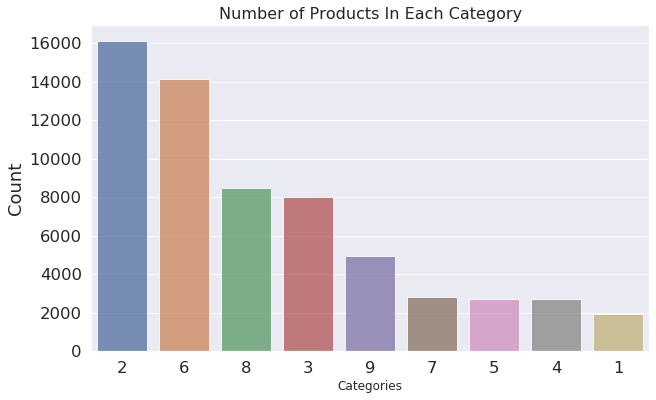

In [173]:
# Plotting a bar chart for the target values
category_count = df.target.value_counts()
plt.figure(figsize=(10,6))
sns.barplot(category_count.index, category_count.values,
            order=category_count.index,
            alpha=0.8)
plt.title('Number of Products In Each Category', fontdict={'fontsize': 16})
plt.ylabel('Count')
plt.xlabel('Categories', fontdict={'fontsize': 12});

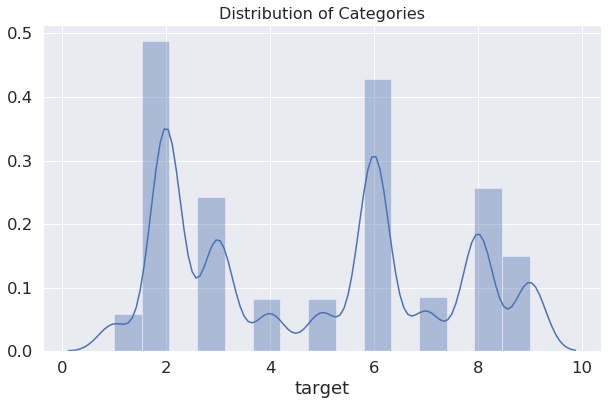

In [177]:
# Visualize distribution

plt.figure(figsize=(10,6))
sns.distplot(df.target, bins=15)
plt.title('Distribution of Categories', fontdict={'fontsize': 16});

In [11]:
# Split into features and label

X = df.drop('target', axis=1)
y = df.target

# Split into test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

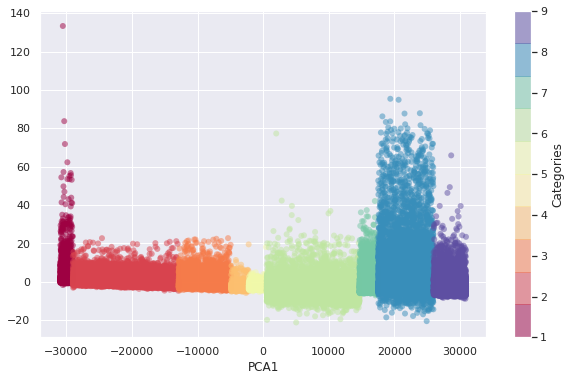

In [12]:
# Visualize dataset with PCA
from sklearn.decomposition import PCA

# instantiate model with 2 dimensions
pca = PCA(2)

# project from 93 to 2 dimensions
projected = pca.fit_transform(df)

# plot
plt.figure(figsize=(10,6))
plt.scatter(projected[:,0], projected[:,1],
            c=df.target, edgecolor='none', alpha=0.5,
            cmap=plt.get_cmap('Spectral', 10))
plt.xlabel('PCA1')
plt.colorbar(label='Categories');

The full data is a 93-dimensional point cloud. These pointr are the projection of each data pointAlong the directions with largest variance.

See [Principal Component Analysis (Data Science Handbook)](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html).

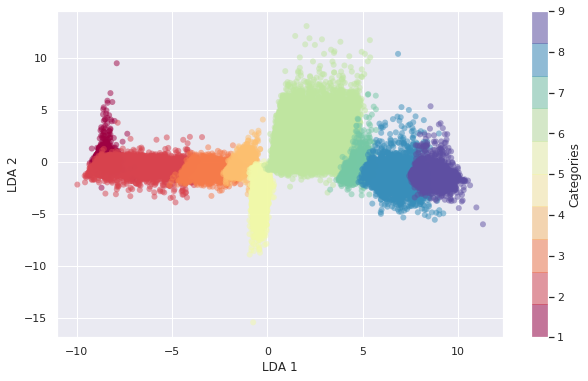

In [13]:
# Visualize dataset with LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# instantiate model with 2 dimensions
lda = LinearDiscriminantAnalysis(n_components=2)

# project from 93 to 2 dimensions
projected = lda.fit_transform(X, y)

# plot
plt.figure(figsize=(10,6))
plt.scatter(projected[:,0], projected[:,1],
            c=df.target, edgecolor='none', alpha=0.5,
            cmap=plt.get_cmap('Spectral', 10))
plt.xlabel('LDA 1')
plt.ylabel('LDA 2')
plt.colorbar(label='Categories');

## 5. Data Modelling

### Dimensionality Reduction with PCA

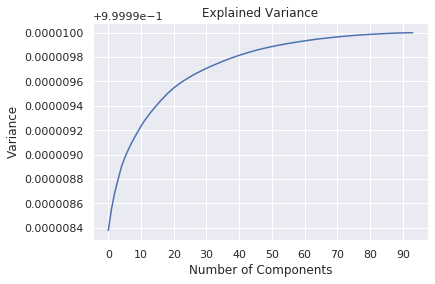

In [14]:
# Fitting the PCA algorithm with our Data
pca = PCA().fit(X)

# Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xticks(np.arange(0, 100, step=10))
plt.xlabel('Number of Components')
plt.ylabel('Variance')
plt.title('Explained Variance');

**Note**: With 80 components, we preserve almost 100% of the total variance of the data.

In [15]:
# Reduce dimensionality with PCA

# Create PCA
pca = PCA(n_components=80, whiten=True)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

X_train_pca.shape, X_test_pca.shape

((49502, 80), (12376, 80))

### Naive Gaussian Bayes

In [16]:
# Instantiate Gaussian Naive Bayes and fit
naive_bayes_pca_clf = GaussianNB().fit(X_train_pca, y_train)

In [81]:
# Create k-fold cross-validation
kf = KFold(n_splits=10,
           shuffle=True,
           random_state=42)

# Create helper function for cross-validated scores
def average_score_on_cross_val_classification(clf, X, y, cv=kf):
    """
    Evaluates a given model/estimator using cross-validation (5 folds)
    and returns a dict containing the absolute vlues of the average (mean) scores
    for classification models.

    clf: scikit-learn classification
    X: features (no labels)
    y: labels
    """
    # Create a dictionary of scoring metrics
    scoring = {'accuracy': 'accuracy',
               'precision': make_scorer(precision_score, average='weighted'),
               'recall': make_scorer(recall_score, average='weighted'),
               'f1': make_scorer(f1_score, average='weighted'),
               'log loss': 'neg_log_loss'}
    
    # Score metrics on cross-validated dataset
    scores_dict = cross_validate(clf, X, y, scoring=scoring, cv=kf, n_jobs=-1)
    
    # return the average scores for each metric
    return {metric: abs(round(np.mean(scores), 5)) for metric, scores in scores_dict.items()}

In [82]:
# Score model
naive_bayes_pca_metrics = average_score_on_cross_val_classification(naive_bayes_pca_clf, X, y)
naive_bayes_pca_metrics

{'fit_time': 0.40906,
 'score_time': 0.21274,
 'test_accuracy': 0.81161,
 'test_precision': 0.82937,
 'test_recall': 0.81161,
 'test_f1': 0.80199,
 'test_log loss': 2.1374}

In [83]:
# Make predictions
y_preds_naive_bayes_pca = naive_bayes_pca_clf.predict(X_test_pca)
y_preds_naive_bayes_proba_pca = naive_bayes_pca_clf.predict_proba(X_test_pca)

In [84]:
# Multi-class log loss on predictions
log_loss(y_test, y_preds_naive_bayes_proba_pca)

20.626681027582507

**Note**: In the competition, the best score was 0.38242!
Naive Gaussian Bayes doesn't do well here!

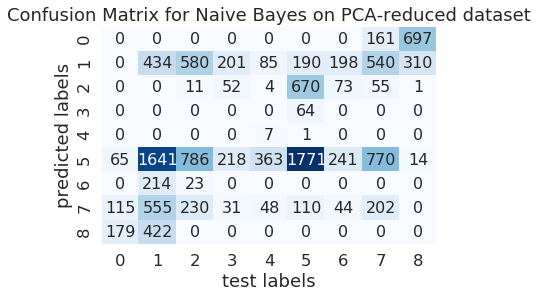

In [85]:
# Confusion Matrix
naive_bayes_pca_conf_mat = confusion_matrix(y_test, y_preds_naive_bayes_pca)

sns.set(font_scale=1.5)
sns.heatmap(naive_bayes_pca_conf_mat.T, annot=True, fmt='d', annot_kws={'size': 16}, cmap='Blues', cbar=False)
plt.xlabel('test labels')
plt.ylabel('predicted labels')
plt.title('Confusion Matrix for Naive Bayes on PCA-reduced dataset');

### Random Forest Classification

In [86]:
# Initialize and fit Random Forest Classifier
rf_pca_clf = RandomForestClassifier().fit(X_train_pca, y_train)

In [87]:
# Show scores
rf_pca_metrics = average_score_on_cross_val_classification(rf_pca_clf, X, y)
rf_pca_metrics

{'fit_time': 15.69801,
 'score_time': 0.43611,
 'test_accuracy': 0.99438,
 'test_precision': 0.99438,
 'test_recall': 0.99438,
 'test_f1': 0.99437,
 'test_log loss': 0.14257}

In [88]:
# Create predictions
y_preds_rf_pca = rf_pca_clf.predict(X_test_pca)
y_preds_rf_proba_pca = rf_pca_clf.predict_proba(X_test_pca)

In [89]:
log_loss(y_test, y_preds_rf_proba_pca)

3.579856258952274

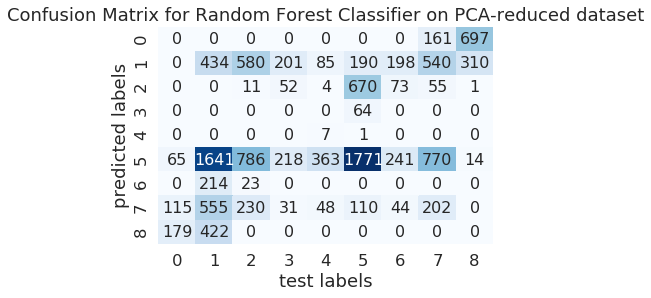

In [90]:
# Confusion Matrix
naive_bayes_pca_conf_mat = confusion_matrix(y_test, y_preds_naive_bayes_pca)

sns.set(font_scale=1.5)
sns.heatmap(naive_bayes_pca_conf_mat.T, annot=True, fmt='d', annot_kws={'size': 16}, cmap='Blues', cbar=False)
plt.xlabel('test labels')
plt.ylabel('predicted labels')
plt.title('Confusion Matrix for Random Forest Classifier on PCA-reduced dataset');

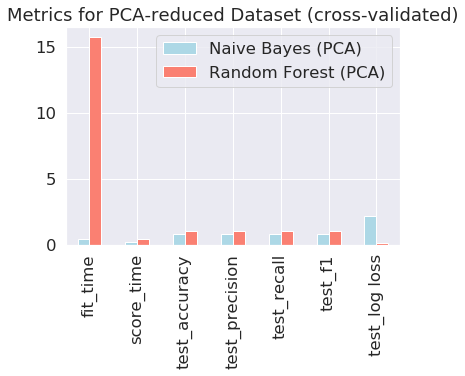

In [91]:
# Visualize cross-validated metrics
compare_metrics_df = pd.DataFrame({'Naive Bayes (PCA)': naive_bayes_pca_metrics,
                                   'Random Forest (PCA)': rf_pca_metrics},
                                  index=naive_bayes_pca_metrics.keys())

compare_metrics_df.plot(title='Metrics for PCA-reduced Dataset (cross-validated)',
                        color=['lightblue', 'salmon'],
                        kind='bar');

### Experiments With Dimenensionality Reduction and Feature Selection

#### Linear Discriminant Analysis

Find out how many components are required to get above 0.95 variance threshold.

See also [Chris Albon's notes](https://chrisalbon.com/machine_learning/feature_engineering/lda_for_dimensionality_reduction/).

From [Machine Learning Mastery](https://machinelearningmastery.com/linear-discriminant-analysis-for-machine-learning/):
> Logistic regression is a simple and powerful linear classification algorithm. It also has limitations that suggest at the need for alternate linear classification algorithms.

> * **Two-Class Problems**. Logistic regression is intended for two-class or binary classification problems. It can be extended for multi-class classification, but is rarely used for this purpose.
> * **Unstable With Well Separated Classes**. Logistic regression can become unstable when the classes are well separated.
> * **Unstable With Few Examples**. Logistic regression can become unstable when there are few examples from which to estimate the parameters.

> Linear Discriminant Analysis does address each of these points and is the go-to linear method for multi-class classification problems. Even with binary-classification problems, it is a good idea to try both logistic regression and linear discriminant analysis.

In [98]:
# Standardize features
X_train_std = StandardScaler().fit_transform(X_train)

In [99]:
# Create and fit LDA
lda = LinearDiscriminantAnalysis(n_components=None)
features_lda = lda.fit(X_train_std, y_train)

# Create array of explained variance rations
lda_var_ratios = lda.explained_variance_ratio_

In [100]:
# Function for selecting n components
def select_n_lda_components(var_ratio, goal_var):
    # Set initial variance
    total_variance = 0.0
    # Set initial number of components
    n_components = 0
    # loop
    for explained_variance in var_ratio:
        # Add explained variance to total
        total_variance += explained_variance
        # Increment number of components
        n_components += 1
        # Stop loop if goal level of explained variance is met
        if total_variance >= goal_var:
            break
    
    return n_components

In [101]:
lda_components = select_n_lda_components(lda_var_ratios, 0.95)
lda_components

4

#### Truncated Singular Value Decomposition (TSVD)

The dataset shows that this challenge provides a **sparse feature matrix**.

_Truncated SVD_ is an ideal candidate:

From the [sci-kit learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html):

> This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with scipy.sparse matrices efficiently

See also [Chris Albon's notes](https://chrisalbon.com/machine_learning/feature_engineering/dimensionality_reduction_on_sparse_feature_matrix/).

In [102]:
# Create and run TSDV with one less than number of (sparse) features
tsdv = TruncatedSVD(n_components=X_train_std.shape[1]-1)
features_tsdv = tsdv.fit(X_train)

# List of explained variances
tsd_var_ratios = tsdv.explained_variance_ratio_

In [103]:
# Create a function
def select_n_tsdv_components(var_ratio, goal_var):
    # Set initial variance
    total_variance = 0.0
    # Set initial number of components
    n_components = 0
    # loop
    for explained_variance in var_ratio:
        # Add explained variance to total
        total_variance += explained_variance
        # Increment number of components
        n_components += 1
        # Stop loop if goal level of explained variance is met
        if total_variance >= goal_var:
            break
    
    return n_components 

In [104]:
tsdv_components = select_n_tsdv_components(tsd_var_ratios, 0.95)
tsdv_components

1

### Create Pipeline And Compare Three Different Models

In [105]:
# Create features union
# Standardizes feature matrix, uses TSVD, then selects 6 best features
features = []
features.append(('standardize', StandardScaler()))
features.append(('tsdv', TruncatedSVD(n_components=1)))
features.append(('select_best', SelectKBest(k=6)))
feature_union = FeatureUnion(features)

In [107]:
# Create pipeline
# combines feature union with scikit-learn estimator

# Logistic Regression
estimators_log_r =  []
estimators_log_r.append(('feature_union', feature_union))
estimators_log_r.append(('logistic', LogisticRegression(random_state=42)))
model_log_r = Pipeline(estimators_log_r)

# SVC
estimators_svc = []
estimators_svc.append(('feature_union', feature_union))
estimators_svc.append(('svc', SVC(probability=True, random_state=42)))
model_svc = Pipeline(estimators_svc)

# Random Forest
estimators_rf = []
estimators_rf.append(('feature_union', feature_union))
estimators_rf.append(('rf', RandomForestClassifier(n_jobs=-1, random_state=42)))
model_rf = Pipeline(estimators_rf)

models = {'Logistic_Regression': model_log_r,
          'SVC': model_svc,
          'Random_Forest_C': model_rf}

In [108]:
# Run and score all models
np.random.seed(42)
scores = {name: average_score_on_cross_val_classification(model, X, y) for name, model in models.items()}
scores

{'Logistic_Regression': {'fit_time': 12.35525,
  'score_time': 0.06912,
  'test_accuracy': 0.71387,
  'test_precision': 0.71022,
  'test_recall': 0.71387,
  'test_f1': 0.68102,
  'test_log loss': 0.99125},
 'SVC': {'fit_time': 318.41716,
  'score_time': 40.90063,
  'test_accuracy': 0.99937,
  'test_precision': 0.99937,
  'test_recall': 0.99937,
  'test_f1': 0.99937,
  'test_log loss': 0.01376},
 'Random_Forest_C': {'fit_time': 12.02873,
  'score_time': 0.70435,
  'test_accuracy': 0.99992,
  'test_precision': 0.99992,
  'test_recall': 0.99992,
  'test_f1': 0.99992,
  'test_log loss': 0.02499}}

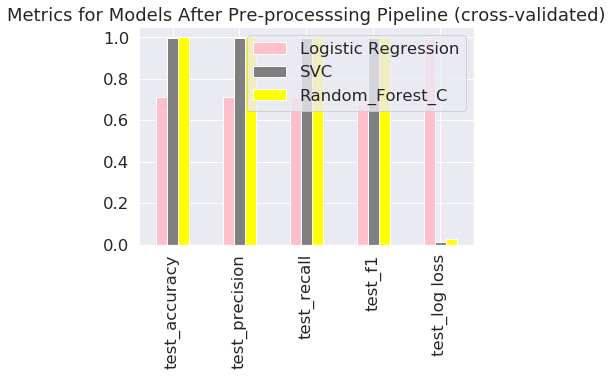

In [115]:
# Visualize cross-validated metrics

# Create DataFrame with all scores
compare_pipeline_metrics_df = pd.DataFrame({'Logistic Regression': scores['Logistic_Regression'],
                                            'SVC': scores['SVC'],
                                            'Random_Forest_C': scores['Random_Forest_C']},
                                            index=scores['SVC'].keys())

# Drop rows: fit_time, score_time
compare_pipeline_metrics_df.drop(['fit_time', 'score_time'], inplace=True)

compare_pipeline_metrics_df.plot(title='Metrics for Models After Pre-processsing Pipeline (cross-validated)',
                        color=['pink', 'gray', 'yellow'],
                        kind='bar');

### Explore Support Vector Machine

In [116]:
# Create features pipeline
features = []
features.append(('standardize', StandardScaler()))
features.append(('tsdv', TruncatedSVD(n_components=tsdv_components)))
features.append(('select_best', SelectKBest(k=6)))
feature_union = FeatureUnion(features)

In [117]:
# Create SVC pipeline
estimators_svc = []
estimators_svc.append(('feature_union', feature_union))
estimators_svc.append(('svc', SVC(class_weight='balanced', probability=True, random_state=42)))

model_svc = Pipeline(estimators_svc)
model_svc

Pipeline(memory=None,
         steps=[('feature_union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('standardize',
                                                 StandardScaler(copy=True,
                                                                with_mean=True,
                                                                with_std=True)),
                                                ('tsdv',
                                                 TruncatedSVD(algorithm='randomized',
                                                              n_components=1,
                                                              n_iter=5,
                                                              random_state=None,
                                                              tol=0.0)),
                                                ('select_best',
                                                 SelectKBest(k=6,
                        

In [118]:
%time

model_svc.fit(X_train, y_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


Pipeline(memory=None,
         steps=[('feature_union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('standardize',
                                                 StandardScaler(copy=True,
                                                                with_mean=True,
                                                                with_std=True)),
                                                ('tsdv',
                                                 TruncatedSVD(algorithm='randomized',
                                                              n_components=1,
                                                              n_iter=5,
                                                              random_state=None,
                                                              tol=0.0)),
                                                ('select_best',
                                                 SelectKBest(k=6,
                        

In [119]:
# Make predictions
y_preds = model_svc.predict(X_test)
y_preds_proba = model_svc.predict_proba(X_test)

In [120]:
# Multi-class logarithmic loss
log_loss(y_test, y_preds_proba)

0.013947345837581707

**Note**: The model scores significantly better than the winner in the original competition.
It's been 5 years, so did sci-kit learn get so much better or is something wrong here?

In [181]:
# Check cross-validated scores again
model_svc_scores = average_score_on_cross_val_classification(model_svc, X, y)
model_svc_scores

{'fit_time': 410.14763,
 'score_time': 53.80712,
 'test_accuracy': 0.9441,
 'test_precision': 0.95526,
 'test_recall': 0.9441,
 'test_f1': 0.94625,
 'test_log loss': 0.01377}

In [191]:
# Create dataframe from dictionary, drop fit_time and score_time
model_svc_scores_df = pd.DataFrame(model_svc_scores, index=['SVC']).T
model_svc_scores_df.drop(['fit_time', 'score_time'], inplace=True)

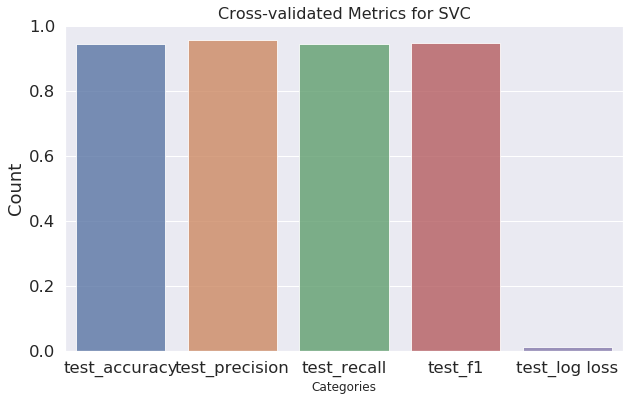

In [242]:
# Visualize scores
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=model_svc_scores_df.index,
            y=model_svc_scores_df['SVC'],
            alpha=0.8)
ax.set_title('Cross-validated Metrics for SVC', fontdict={'fontsize': 16})
ax.set_ylabel('Count')
ax.set_xlabel('Categories', fontdict={'fontsize': 12});

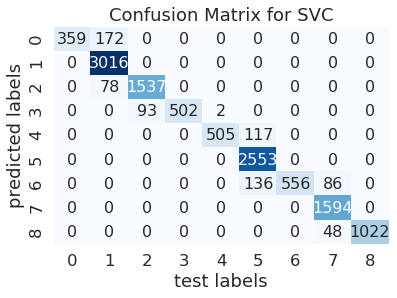

In [243]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_preds)

sns.set(font_scale=1.5)
sns.heatmap(conf_mat.T, annot=True, fmt='d', annot_kws={'size': 16}, cmap='Blues', cbar=False)
plt.xlabel('test labels')
plt.ylabel('predicted labels')
plt.title('Confusion Matrix for SVC');

**Note**: The confusion matrix suggests that the model really does a good job on predicting the correct shopping category.